In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

$x_i = \frac{i}{n} + \frac{1}{10} \sin \left( \frac{2 \pi i}{n} \right)$

In [2]:
def get_D(xs):
    n = len(xs)-1
    D = np.empty((n+1,n+1))
    for l in range(n+1):
        for i in range(n+1):
            if i == l:
                term = 0.0
                for k in range(n+1):
                    if k == i:
                        continue
                    term += 1.0/(xs[i] - xs[k])
                D[l,l] = term
            else:
                term = 1.0/(xs[i] - xs[l])
                for j in range(n+1):
                    if (j == l) or (j == i):
                        continue
                    term *= (xs[l] - xs[j])/(xs[i] - xs[j])    
                D[l,i] = term
    return D

In [3]:
def mesh(n):
    i = np.arange(n+1, dtype=np.float)
    return i/n + 0.1*np.sin(2*np.pi*i/n) 

In [4]:
def five_point_mesh(xs):
    assert len(xs) == 5
    D = get_D(xs)
    return D[2,:]

In [5]:
def get_stencils(xs):
    n = len(xs)-1
    Dstencils = np.empty((n-3, 5))
    for i in range(n-3):
        Dstencils[i,:] = five_point_mesh(xs[i:i+5])
    return Dstencils

In [6]:
def apply_stencil(Dstencils, fvals):
    fprime_numerical = np.empty(len(fvals)-4)
    for i in range(len(fvals)-4):
        fprime_numerical[i] = np.dot(Dstencils[i,:], fvals[i:i+5])
    return fprime_numerical

In [7]:
def errors(xs, f, fprime, norm_orders):
    n = len(xs)-1
    Dstencils = get_stencils(xs)
    fvals = f(xs)
    fprimevals = fprime(xs[2:-2])
    fmatvals = apply_stencil(Dstencils, fvals)
    return np.array([
            np.linalg.norm(fprimevals - fmatvals, ord=norm_order)
            for norm_order in norm_orders
        ])

In [8]:
def f(x):
    return np.tanh(10*x - 5)

In [9]:
def fprime(x):
    return 10/np.cosh(5-10*x)**2

In [12]:
nmin = 6
nmax = 200
norm_errors = np.empty((nmax - nmin, 3))
ns = np.arange(nmin, nmax)
for n in range(nmin, nmax):
    norm_errors[n-nmin,:] = errors(mesh(n), f, fprime, [1,2,float('inf')])

In [20]:
nregressionmin = 50
slopes = np.empty(3)
for i in range(3):
    slopes[i], _, _, _, _ = linregress(np.log(ns[nregressionmin:]),
                                       np.log(norm_errors[nregressionmin:,i]))

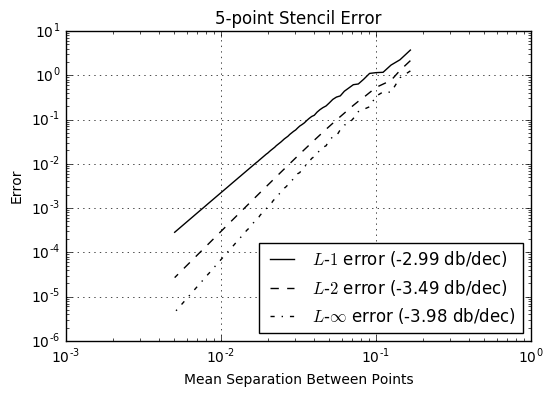

In [32]:
plt.loglog(1.0/np.arange(nmin, nmax), norm_errors[:,0], 
           label=r"$L$-$1$ error ({:1.3} db/dec)".format(slopes[0]), 
           linestyle="solid", color="black")
plt.loglog(1.0/np.arange(nmin, nmax), norm_errors[:,1], 
           label=r"$L$-$2$ error ({:1.3} db/dec)".format(slopes[1]), 
           linestyle="dashed", color="black")
plt.loglog(1.0/np.arange(nmin, nmax), norm_errors[:,2], 
           label=r"$L$-$\infty$ error ({:1.3} db/dec)".format(slopes[2]), 
           linestyle='-.', color="black")
plt.legend(loc="lower right")
plt.grid(True)
plt.title("5-point Stencil Error")
plt.xlabel("Mean Separation Between Points")
plt.ylabel("Error")